In [1]:
from openai import OpenAI

import pandas as pd
import random
import json

import googlemaps
from datetime import datetime

import re
import requests

import os
import matplotlib.pyplot as plt

import numpy as np
from scipy.interpolate import interp1d

import math


In [2]:
json_file_path = 'goals_data.json'

In [3]:
# Read the JSON file
with open(json_file_path, 'r') as file:
    data = json.load(file)

# Initialize variables
initial_location = data[1]['initial']
goals_list = data[1]['goals']
observations = data[2]['observations']

# Print or use the variables as needed
print("Initial Location:", initial_location)
print("Goals List:", goals_list[1])
print("observations:", observations)

Initial Location: Bristol, UK
Goals List: Derby, UK
observations: [[51.4551987, -2.5868899], [51.4597708, -2.5840761], [52.3522323, -1.809647], [52.9488481, -1.1506018], [52.95400799999999, -1.1552171]]


In [4]:
file_path = "locations_with_lat_lng.txt"
df = pd.read_csv(file_path)

def get_lat_lng(location):
    # Find the row corresponding to the input location
    row = df[df['Locations'] == location]

    # If location not found in DataFrame, return None
    if row.empty:
        return None, None
    
    # Extract latitude and longitude from the DataFrame
    return row['Latitude'].values[0], row['Longitude'].values[0]

In [5]:


def calculate_distance(point1, point2):
    R = 6371e3  # Earth radius in meters
    lat1, lon1 = point1
    lat2, lon2 = point2
    φ1 = math.radians(lat1)
    φ2 = math.radians(lat2)
    Δφ = math.radians(lat2 - lat1)
    Δλ = math.radians(lon2 - lon1)

    a = math.sin(Δφ / 2) * math.sin(Δφ / 2) + math.cos(φ1) * math.cos(φ2) * math.sin(Δλ / 2) * math.sin(Δλ / 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    return R * c  # Distance in meters


In [6]:
def calculate_direction(point1, point2):
    lat1, lon1 = math.radians(point1[0]), math.radians(point1[1])
    lat2, lon2 = math.radians(point2[0]), math.radians(point2[1])
    
    Δλ = lon2 - lon1

    y = math.sin(Δλ) * math.cos(lat2)
    x = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(Δλ)
    
    initial_bearing = math.atan2(y, x)
    
    # Convert to degrees and ensure it's within range 0 to 360
    initial_bearing = (math.degrees(initial_bearing) + 180) % 360
    
    return initial_bearing

In [7]:
def calculate_route_distance(origin, destination):
    directions_result = gmaps.directions(origin, destination, mode="driving")
    
    # Check if directions are available
    if not directions_result or not directions_result[0]['legs']:
        return None  # Return None if no directions are available
    
    total_distance = 0  # Initialize total distance
    
    # Calculate total distance of the route
    for leg in directions_result[0]['legs']:
        total_distance += leg['distance']['value']  # Add leg distance to total

    return total_distance

In [8]:
with open(json_file_path, 'r') as file:
    data = json.load(file)

datalength = len(data)

In [9]:
for current_id in range(3):
    goals = data[current_id]['goals']
    if current_id % 5 == 0: 
            for goal in range(len(goals)):
                print(data[current_id]['id'], data[current_id]['initial'], goals[goal])
    
    # for goal in range(len(goals)):
    #     print(data[current_id]['id'])
        # route_points = calculate_route_points(data[current_id]['initial'], goals[goal])
        # print(data[current_id]['id'],data[current_id]['initial'], goals[goal])

1.2.1 Bristol, UK Nottingham, UK
1.2.1 Bristol, UK Derby, UK


In [10]:
similarity_dic_google = {}
intent_dic_google = {}

for current_id in range(datalength):
    intent = {}
    point_distance_array = []
    
    goals = data[current_id]['goals']

    print(data[current_id]['id'], end=' ')
    
    for goal in range(len(goals)):

        point_distance1 = calculate_direction(get_lat_lng(data[current_id]['initial']), get_lat_lng(goals[goal]))
        point_distance2 = calculate_direction(get_lat_lng(data[current_id]['initial']), data[current_id]['observations'][-1])
        point_distance = point_distance2 - point_distance1
        if point_distance < 0:
            point_distance = -point_distance
        point_distance_array.append(point_distance)
    # print(point_distance_array)   
 
    
    # Find the minimum and maximum distances for each goal
    min_distance = min(point_distance_array)
    max_distance = max(point_distance_array)
    
    # Calculate intent percentages for each goal
    intent_percentages = [100 - ((distance - min_distance) / (max_distance - min_distance) * 100) for distance in point_distance_array]
    
    # Normalize intent percentages so that their sum is 100%
    total_intent_percentage = sum(intent_percentages)
    if total_intent_percentage != 0:  # Avoid division by zero
        intent_percentages = [percentage * 100 / total_intent_percentage for percentage in intent_percentages]
    
    # Store intent percentages for each goal in the dictionary
    for i, goal in enumerate(goals):
        intent[goal] = format(intent_percentages[i], '.2f')

    # Store intent in the dictionary for the current data ID
    intent_dic_google[data[current_id]['id']] = intent

1.2.1 1.2.3 1.2.5 1.2.10 1.2.15 1.5.1 1.5.3 1.5.5 1.5.10 1.5.15 1.10.1 1.10.3 1.10.5 1.10.10 1.10.15 1.15.1 1.15.3 1.15.5 1.15.10 1.15.15 2.2.1 2.2.3 2.2.5 2.2.10 2.2.15 2.5.1 2.5.3 2.5.5 2.5.10 2.5.15 2.10.1 2.10.3 2.10.5 2.10.10 2.10.15 2.15.1 2.15.3 2.15.5 2.15.10 2.15.15 3.2.1 3.2.3 3.2.5 3.2.10 3.2.15 3.5.1 3.5.3 3.5.5 3.5.10 3.5.15 3.10.1 3.10.3 3.10.5 3.10.10 3.10.15 3.15.1 3.15.3 3.15.5 3.15.10 3.15.15 4.2.1 4.2.3 4.2.5 4.2.10 4.2.15 4.5.1 4.5.3 4.5.5 4.5.10 4.5.15 4.10.1 4.10.3 4.10.5 4.10.10 4.10.15 4.15.1 4.15.3 4.15.5 4.15.10 4.15.15 5.2.1 5.2.3 5.2.5 5.2.10 5.2.15 5.5.1 5.5.3 5.5.5 5.5.10 5.5.15 5.10.1 5.10.3 5.10.5 5.10.10 5.10.15 5.15.1 5.15.3 5.15.5 5.15.10 5.15.15 

In [11]:
# intent_dic_google

In [12]:
count = 0
TP_google = 0
FN_google = 0
FP_google = 0
TN_google = 0
for id in intent_dic_google:
    highest_intent, highest_score = max(intent_dic_google[id].items(), key=lambda x: float(x[1]))
    
    # Check if the highest scoring intent matches the intent_goal
    if highest_intent == data[count]['intent_goal']:
        TP_google += 1
        TN_google += len(intent_dic_google[id]) - 1
    else:
        print(data[count]['id'])
        FN_google += 1
        FP_google += len(intent_dic_google[id]) - 1
    
    count += 1   
TPR_recall_google = TP_google/(TP_google + FN_google)
Precision_google = TP_google/(TP_google + FP_google)
FNR_google = FN_google/(FN_google + TP_google)
FPR_google = FP_google/max(FP_google + TN_google, 1)

F1_google = (2*Precision_google*TPR_recall_google)/(Precision_google + TPR_recall_google)
# TPR_recall

1.2.1
1.5.1
3.2.3
3.5.3
3.10.3
3.15.3
5.2.3
5.5.1
5.5.3
5.10.1
5.10.3
5.15.1
5.15.3


In [13]:
TP_google

87

In [14]:
TPR_recall_google

0.87

In [15]:
obs_data = [[] for _ in range(4)]

for id in intent_dic_google:
    # Find the highest scoring intent

    id_parts = id.split(".")
    
    # Check if the last part of the ID ends with "2"
    if id_parts[1] == '2':
      
        obs_data[0].append(id)
    if id_parts[1] == '5':
     
        obs_data[1].append(id)
    if id_parts[1] == '10':
      
        obs_data[2].append(id)
    if id_parts[1] == '15':
     
        obs_data[3].append(id)
# obs_data


In [16]:
# Initialize counts

TPR_recalls_google, FNRs_google, FPRs_google, F1s_google = [], [], [], []

count = 0  # Reset count for each iteration


for obs in range(len(obs_data)):
    TP_google, FN_google, FP_google, TN_google = 0, 0, 0, 0
    for id_str in obs_data[obs]:
        for data_dict in data:
            if data_dict['id'] == id_str:
                highest_intent, highest_score = max(intent_dic_google[id_str].items(), key=lambda x: float(x[1]))
                
                # Check if the highest scoring intent matches the intent_goal
                if highest_intent == data_dict['intent_goal']:
                    # print(data_dict['id'])
                    TP_google += 1
                    TN_google += len(intent_dic_google[id_str]) - 1
                else:
                    # print(data_dict['id'])
                    FN_google += 1
                    FP_google += len(intent_dic_google[id_str]) - 1
                break       

 
    # print(TP_ai)
    # print(FN_ai)
    TPR_recall_google = TP_google/(TP_google + FN_google)
    Precision_google = TP_google/(TP_google + FP_google)
    FNR_google = FN_google/(FN_google + TP_google)
    FPR_google = FP_google/max(FP_google + TN_google, 1)
    
    # F1s_google.append(round((2*Precision_google*TPR_recall_google)/(Precision_google + TPR_recall_google), 2))
    TPR_recalls_google.append(TPR_recall_google)
    FNRs_google.append(FNR_google)
    FPRs_google.append(FPR_google)


In [17]:
TPR_recalls_google

[0.88, 0.84, 0.88, 0.88]

In [18]:
FNRs_google

[0.12, 0.16, 0.12, 0.12]

In [19]:
FPRs_google

[0.12, 0.16, 0.12, 0.12]

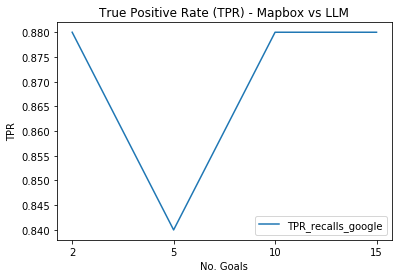

In [20]:
# Define the x-axis values
x = ['2', '5', '10', '15']

# Plot TPR for Mapbox and AI
plt.plot(x, TPR_recalls_google, label='TPR_recalls_google')

# Add labels and title
plt.xlabel('No. Goals')
plt.ylabel('TPR')
plt.title('True Positive Rate (TPR) - Mapbox vs LLM')
plt.legend()

# Show the plot
plt.show()

In [21]:
obs_data = [[] for _ in range(5)]

for id in intent_dic_google:
    # Find the highest scoring intent

    id_parts = id.split(".")
    
    # Check if the last part of the ID ends with "2"
    if id_parts[-1] == '1':
      
        obs_data[0].append(id)
    if id_parts[-1] == '3':
     
        obs_data[1].append(id)
    if id_parts[-1] == '5':
      
        obs_data[2].append(id)
    if id_parts[-1] == '10':
     
        obs_data[3].append(id)
    if id_parts[-1] == '15':

        obs_data[4].append(id)
# obs_data


In [22]:
# Initialize counts

TPR_recalls_google, FNRs_google, FPRs_google, F1s_google = [], [], [], []

count = 0  # Reset count for each iteration


for obs in range(len(obs_data)):
    TP_google, FN_google, FP_google, TN_google = 0, 0, 0, 0
    for id_str in obs_data[obs]:
        for data_dict in data:
            if data_dict['id'] == id_str:
                highest_intent, highest_score = max(intent_dic_google[id_str].items(), key=lambda x: float(x[1]))
                
                # Check if the highest scoring intent matches the intent_goal
                if highest_intent == data_dict['intent_goal']:
                    # print(data_dict['id'])
                    TP_google += 1
                    TN_google += len(intent_dic_google[id_str]) - 1
                else:
                    # print(data_dict['id'])
                    FN_google += 1
                    FP_google += len(intent_dic_google[id_str]) - 1
                break        

 
    # print(TP_ai)
    # print(FN_ai)
    TPR_recall_google = TP_google/(TP_google + FN_google)
    Precision_google = TP_google/(TP_google + FP_google)
    FNR_google = FN_google/(FN_google + TP_google)
    FPR_google = FP_google/max(FP_google + TN_google, 1)
    
    # F1s_google.append(round((2*Precision_google*TPR_recall_google)/(Precision_google + TPR_recall_google), 2))
    TPR_recalls_google.append(TPR_recall_google)
    FNRs_google.append(FNR_google)
    FPRs_google.append(FPR_google)


In [23]:
TPR_recalls_google

[0.75, 0.6, 1.0, 1.0, 1.0]

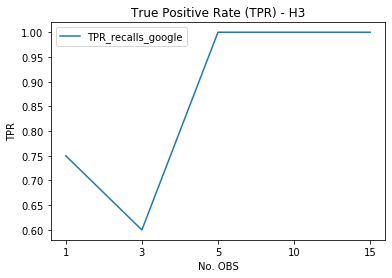

In [24]:
# Define the x-axis values
x = ['1', '3', '5', '10', '15']

# Plot TPR for Mapbox and AI
plt.plot(x, TPR_recalls_google, label='TPR_recalls_google')

# Add labels and title
plt.xlabel('No. OBS')
plt.ylabel('TPR')
plt.title('True Positive Rate (TPR) - H3')
plt.legend()

# Show the plot
plt.show()